<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

## Описание признаков

Описание признаков
bodyType - тип кузова
brand - марка автомобиля
car_url - адрес страницы с объявлением
color - цвет автомобиля
complectation_dict - словарь с параметрами комплектации авто
description - описание автомобиля
engineDisplacement - объем двигателя
enginePower - мощность двигателя
equipment_dict - словарь оснащения авто
fuelType - тип топлива
image - изображение
mileage - пробег
modelDate - дата выпуска модели
model_info - информация о модели
model_name - название модели
name - имя
numberOfDoors - кол-во дверей
parsing_unixtime - когда был произведен парсинг данных
priceCurrency - валюта
productionDate - год производства
sell_id
super_gen - словарь с дополинтельной информацией
vehicleConfiguration - конфигурация транспортного средства
vehicleTransmission - трансмиссия
vendor - страна-изготовитель
Владельцы - кол-во владельцев
Владение - период владения
ПТС
Привод
Руль
Состояние
Таможня

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

## Импорт библиотек

In [1]:
from IPython.core.display import display, HTML

import os
import re

import pandas as pd
from pandas import Series

import numpy as np
from numpy import mean

import pandas_profiling
from pandas_profiling import ProfileReport

import collections

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
from sklearn.feature_extraction.text import CountVectorizer

from catboost import CatBoostRegressor
import xgboost as xgb

import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')

## Настройка опций

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [4]:
RANDOM_SEED = 42

## Классы и функции для решения задачи

In [5]:
# Класс для обработки признака времени владения автомобилем.

class OwnershipPeriod():
    def __init__(self):
        self.pattern = re.compile('((\d+) (года|год|лет)){0,1}( и ){0,1}((\d+) (месяц)){0,1}')
        
    def get_months_from_ownership_period(self, x):
        '''Функция для подсчета кол-ва месяцев владения автомобилем, осуществляется через 
        преобразование кол-ва лет и месяцев в кол-во месяцев.'''
        search_res = self.pattern.search(str(x))

        years = 0
        months = 0

        if search_res.group(2):
            years = int(search_res.group(2))
        if search_res.group(6):
            months = int(search_res.group(6))

        return years*12 + months

In [6]:
def profile_report(df):
    '''Функция для вызова профайл-отчета о датафрейме'''
    
    if df is None:
        raise TypeError(nameof(df))

    profile = df.profile_report(
        title='Car Price prediction',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': True},
            'phi_k': {'calculate': True},
            'cramers': {'calculate': True},
        },
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat': {'n_obs': 10}
        }
    )

    return profile

In [7]:
def asfloat(x, zero_if_none=False):
    '''Функция для перевода значения в float.'''
    if x is None or x == '':
        if zero_if_none:
            return 0
        else:
            return None
    else:
        return float(x)

In [8]:
def asdict(x):
    '''Функция для замены значений в словаре.'''
    if type(x) != str:
        return None
    
    return eval(x.replace('true', 'True').replace('false', 'False'))

In [9]:
def labeling(col):
    '''Функция для кодирования признаков.'''
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [10]:
def get_log(df, col):
    '''Функция для логарифмирования признака'''
    
    return df[col].apply(lambda x: np.log(x + 1))

In [11]:
# Класс для исследования числовых признаков
class NumericInspector():
    def __init__(self, df):
        self.df = df

    def _prepare_series(self, column, log):
        return self.df[column] if log == False else get_log(self.df, column)

    def _show_plots(self, df_series, title, size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig = sm.qqplot(df_series, fit=True, line='45', ax=ax1)

        fig.suptitle(title, fontsize=20)

        ax2.hist(df_series, bins=20, histtype='bar', align='mid', rwidth=0.8)

        ax3.boxplot(df_series, vert=False)

        ax1.set_title('QQ-plot')
        ax2.set_title('Histogram')
        ax3.set_title('Boxplot')
        
        plt.show()

    def _boundaries(self, df_series):
        q1 = df_series.quantile(q=0.25, interpolation="midpoint")
        q3 = df_series.quantile(q=0.75, interpolation="midpoint")
        IQR = q3 - q1

        return q1 - 1.5*IQR, q3 + 1.5*IQR, q1, q3, IQR

    def _outliers(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)

        return len(df_series[df_series < minb]) + len(df_series[df_series > maxb])

    def _display_result_info(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)
        
        display(HTML(
            f'''
                <div style="text-align: center; margin-bottom: 20px;"> 
                    --- <span style="font-weight: bold;">q1: </span>
                    {np.round(q1, 2)},
                    <span style="font-weight: bold;">q3: </span>
                    {np.round(q3, 2)},
                    <span style="font-weight: bold;">IQR: </span>
                    {np.round(IQR, 2)},
                    <span style="font-weight: bold;">Boundaries: </span>
                    {np.round((minb, maxb), 2)}, 
                    <span style="font-weight: bold;">Outliers: </span>
                    {self._outliers(df_series)} --- 
                </div>
            '''))

    def inspect(self, column, size=5, with_log=True, title=None, title_for_log=None):
        # дефолтное отображение
        title_wl = title if title is not None else f"Inspection for '{column}' without 'log'"
        df_series = self._prepare_series(column, log=False)
        self._show_plots(df_series, title_wl, size)
        self._display_result_info(df_series)

        if with_log:
            # с логарифмированием
            title_fl = title_for_log if title_for_log is not None else f"Inspection for '{column}' with 'log'"
            try:
                df_series = self._prepare_series(column, log=True)
                self._show_plots(df_series, title_fl, size)
                self._display_result_info(df_series)
            except:
                plt.close()
                display(HTML(
                    f'''
                    <div style="text-align: center; margin-bottom: 22px;">
                        <span style="font-size: 20px; font-weight: bold;">Логарифмирование признака не удалось! :( </span>
                    </div>
                    '''))

        display(HTML('<hr style="width:90%; height:2px; border-width:0; color:gray; background-color:gray; margin-bottom: 30px;">'))

In [12]:
def mape(y_true, y_pred):
    '''Функция для определения метрики'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [13]:
# Общий метод для SkLearn регрессоров

def find_best_params(estimator, parameters, x_train, y_train):
    grid = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=parameters,
        random_state=RANDOM_SEED,
        n_iter=100,
        verbose=10,
        n_jobs=2
    )

    grid.fit(x_train, y_train)
    
    print("Best params:", grid.best_params_)
    print("Best score:", grid.best_score_)

## Загрузка и первичный анализ данных

In [14]:
train = pd.read_csv('../input/parsed-data/parsed_data.csv')
test = pd.read_csv('../input/parsed-data/test.csv')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52055 entries, 0 to 52054
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              52055 non-null  object 
 1   brand                 52055 non-null  object 
 2   car_url               52055 non-null  object 
 3   color                 52055 non-null  object 
 4   complectation_dict    10058 non-null  object 
 5   description           50321 non-null  object 
 6   engineDisplacement    52055 non-null  object 
 7   enginePower           52055 non-null  object 
 8   equipment_dict        52055 non-null  object 
 9   fuelType              52055 non-null  object 
 10  image                 0 non-null      float64
 11  mileage               52055 non-null  int64  
 12  modelDate             52055 non-null  int64  
 13  model_info            52055 non-null  object 
 14  model_name            52055 non-null  object 
 15  name               

In [16]:
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      41997
description              1734
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   52055
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                35436
ПТС                         2
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
dtype: int

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [18]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## Подготовка данных

In [19]:
train['sell_id'].duplicated().sum()

0

In [20]:
test['sell_id'].duplicated().sum()

0

In [21]:
train['sample'] = 1 # помечаем трейн
test['sample'] = 0 # помечаем тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем сеты

In [22]:
data['sell_id'].duplicated(keep=False).sum() #Проверяем общий сет на предмет дублирующихся данных в исходных сетах

3544

In [23]:
data[data['sell_id'].duplicated(keep=False)].head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,price
128,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,Состояние нового авто. (цена в автосалоне от 1...,1.4 LTR,150 N12,"{""engine-proof"":true,""glonass"":true,""asr"":true...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,13000,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603226771,RUB,2020,1101109897,"{""id"":""20898379"",""displacement"":1395,""engine_t...",LIFTBACK MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
156,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,чёрный,"{""id"":""21404914"",""name"":""Hockey Edition"",""avai...","Новый автомобиль, приобретался в Автосалоне Fa...",2.0 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,138,2016,"{""code"":""KODIAQ"",""name"":""Kodiaq"",""ru_name"":""Ко...",KODIAQ,2.0d AMT (150 л.с.) 4WD,5,1603226880,RUB,2020,1101313442,"{""id"":""20839377"",""displacement"":1968,""engine_t...",ALLROAD_5_DOORS ROBOT 2.0,роботизированная,EUROPEAN,1 владелец,4 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
226,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,бежевый,NaN,Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,8045,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 AMT (150 л.с.),5,1603227152,RUB,2019,1100210074,"{""id"":""20898391"",""displacement"":1395,""engine_t...",WAGON_5_DOORS ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
405,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серебристый,NaN,Продаю свою машину. Куплена новой в Минске. По...,1.8 LTR,160 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,249197,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,1.8 MT (160 л.с.) 4WD,5,1603227841,RUB,2013,1101303554,"{""id"":""20767690"",""displacement"":1798,""engine_t...",LIFTBACK MECHANICAL 1.8,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
433,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"{""id"":""20803791"",""name"":""Ambition"",""available_...",Продаю автомобиль (производство Чехия) по прич...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,138000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603227943,RUB,2016,1101299678,"{""id"":""20642741"",""displacement"":1395,""engine_t...",WAGON_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 год и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN


In [24]:
data = data.drop_duplicates(subset=['sell_id'], keep='first') # удаляем дубликаты 

In [25]:
# Переименуем столбцы

data.rename(columns={
    'Владельцы': 'owners_number', 
    'Владение': 'ownership_period',
    'ПТС': 'pts', 
    'Привод': 'gear_type',
    'Руль': 'steering_wheel', 
    'Состояние': 'state', 
    'Таможня': 'custom_cleared'
}, inplace=True)

In [26]:
# Преобразуем значения в столбце steering_wheel

data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

In [27]:
# Преобразуем значения в столбце pts

data['pts'] = data['pts'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

In [28]:
# Преобразуем значения в столбце bodyType

data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0])

In [29]:
# Преобразуем значения в столбце engineDisplacement
# Заменим пустые значения на 0, т.к. все они относятся к одному типу

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: asfloat(x[:-4], zero_if_none=True)).astype('float32')

In [30]:
# Преобразуем значения в столбце enginePower

data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4])).astype('int32')

In [31]:
# Преобразуем значения в столбце owners_number

data['owners_number'] = data['owners_number'].apply(lambda x: int(x[0])).astype('int32')

In [32]:
# Преобразуем значения в столбце ownership_period - переводим в месяцы

ownership_processor = OwnershipPeriod()
data['ownership_period'] = data['ownership_period'].apply(ownership_processor.get_months_from_ownership_period).astype('int32')

In [33]:
# Преобразуем строковые величины в словари. 
# Возможно, они потребуются для улучшения точности модели. 
# Из признака super_gen берем значения расхода топлива и разгона.
data['super_gen'] = data['super_gen'].apply(lambda x: eval(x))

data['fuel_rate'] = data['super_gen'].apply(lambda x: x['fuel_rate'] if 'fuel_rate' in x.keys() else 0)

data['acceleration'] = data['super_gen'].apply(lambda x: x['acceleration'] if 'acceleration' in x.keys() else 0)

In [34]:
data['equipment_dict'] = data['equipment_dict'].apply(asdict)

In [35]:
data['complectation_dict'] = data['complectation_dict'].apply(asdict)

In [36]:
# Удаляем лишние и дублирующиеся признаки.
data.drop(columns=[
    'name', 
    'model_info', 
    'image', 
    'vehicleConfiguration', 
    'car_url', 
    'parsing_unixtime',
    'priceCurrency', 
    'super_gen', 
    'state', 
    'custom_cleared'
], inplace=True)

In [37]:
# Выгружаем данные для просмотра в HTML формате

data_profile = profile_report(data)
data_profile.to_file('output.html')

## Обзор данных

1) В датасете представлено 25 признаков.
2) В объединенных данных представлено 84969 наблюдений.
3) Признак bodyType / brand / color содержат много уникальных значений, пропусков нет.
4) Признак словаря комплектаций содержит очень много пустых значений и не может быть использован далее. 
5) Признак description. Скорее всего признак будет удален, возможно, будет проведена обработка признака (векторизация или создание бинарных колонок при наличии того или иного слова/выражения, которые могут быть полезны для модели).
6) Признак объема двигателя. Нулевые значения относятся к электрокарам. Возможно создать отдельный признак принадлежности автомобиля к электрической. Признак довольно информативный, не содержит пропусков. Также попробуем создать категориальный признак объема двигателя.
7) Признак мощности двигателя / пробега.  Распределение смещенное, попробуем логарифмирование, можно попробовать логарифмирование, информативен, пропусков нет. Есть смысл перевести признак в качество категориального.
8) Признак equipment_dict. В виду большого количества пропусков и разницы в ключах на данном этапе невозможно сделать вывод о полезности данного признака, пока оставляем.
9) Признак fuelType. Пропусков нет, информативен, используем далее.
10) Признак model_date / production_date. Пропусков нет, информативен, используем далее.
11) Признак model_name. Пропусков нет, информативен, используем далее.
12) Признак кол-ва дверей. Будем рассматривать как категориальный.
13) Признаки трансмиссии / кол-во владельцев / привод - категориальные, пропусков нет, используем далее. 
14) Признак vendor - Пропусков нет, информативен, используем далее.
15) Признак времени владения. Большая часть данных имеет нулевое значение, информативен, поработаем с ним далее .
16) Признаки ПТС и руля. Пропусков нет, информативен, используем далее.
17) Признаки fuel_rate / acceleration имеют очень много нулевых значений, на данном этапе сложно сделать конкретный выбор по ним, рассмотрим далее.
18) Целевая переменная price. Конечно используем далее. 
19) Также на основании профайлинга видно, что целевая переменная кореллирует с такими признаками, как объем и мощность двигателя, пробег, время разгона, год производства и выпуска автомобиля, кол-во владельцев, расход топлива, тип кузова.

## Разведывательный анализ/Feature engineering

In [38]:
# На основании первичного осмотра данных распределим наши признаки на три категории: числовы, бинарные и категориальные 
# и рассмотрим внимательнее
bin_cols = ['pts', 'steering_wheel']

cat_cols = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_name',
    'numberOfDoors',
    'vehicleTransmission',
    'vendor',
    'owners_number',
    'gear_type'
]

num_cols = [
    'engineDisplacement',
    'enginePower',
    'mileage',
    'modelDate',
    'productionDate',
    'ownership_period',
    'fuel_rate',
    'acceleration'
]

In [39]:
# Закодируем категориальные признаки с помощью LabelEncoder. 
# Снова разделим датасет на обучающую и тестовую выборки и определим вес признаков для целевой переменной.
for col in ['bodyType', 'brand', 'color', 'vendor', 'model_name', 
            'fuelType', 'vehicleTransmission', 'gear_type']:
    labeling(col)

In [40]:
# выделим обучающую выборку и посмотрим распределение данных в зависимости от переменной.

train_data = data.query('sample == 1').drop(['sample'], axis=1)

<AxesSubplot:>

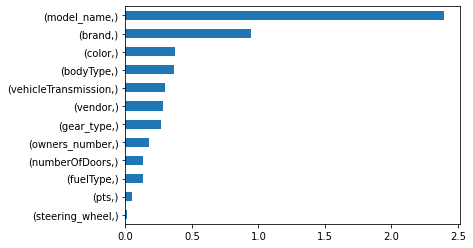

In [41]:
# проанализируем значимость признаков (категориальные + бинарные)

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])

imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

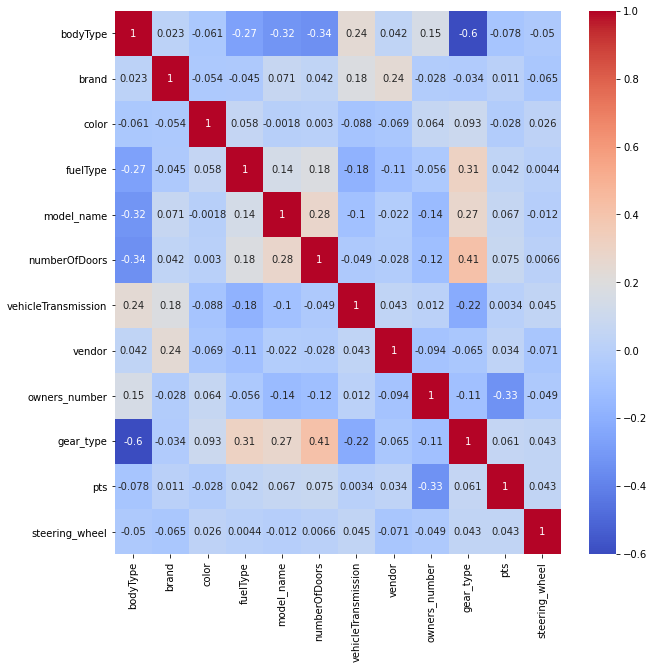

In [42]:
# посмотрим корреляцию

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[cat_cols + bin_cols].corr(method='spearman'), 
                 annot=True, cmap='coolwarm')

Как видно из анализа, модель автомобиля оказывает наибольшее влияние на стоимость автомобиля. 
Менее всего - признак оригинальности ПТС и расположения руля. 
Прослеживается значительная корреляцию между моделью автомобиля и количеством дверей / приводом, привод также хорошо
скоррелирован с типом кузова и количеством дверей соответственно.
Можно попытаться собрать новый признак на основе представленных и посмотреть, как это повлияет на качество модели.

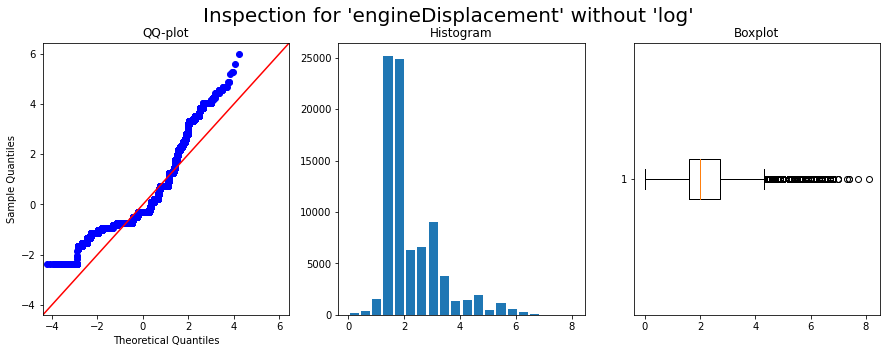

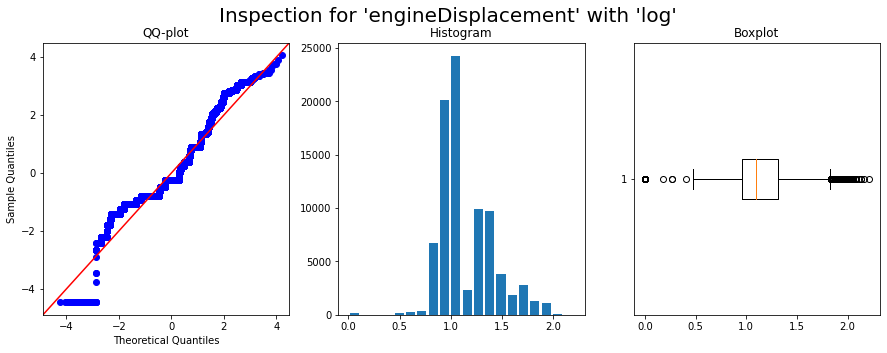

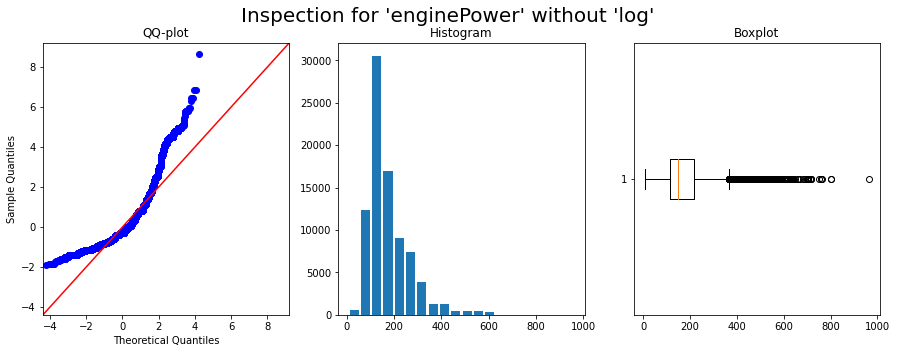

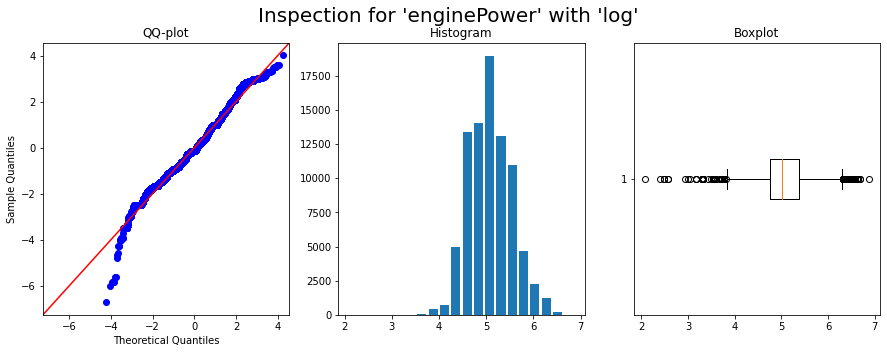

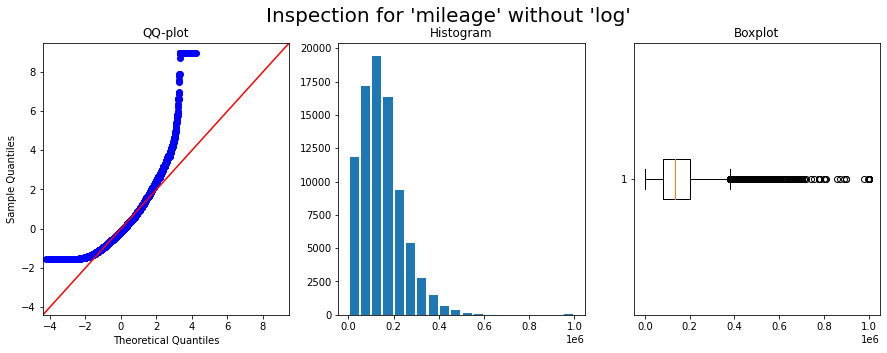

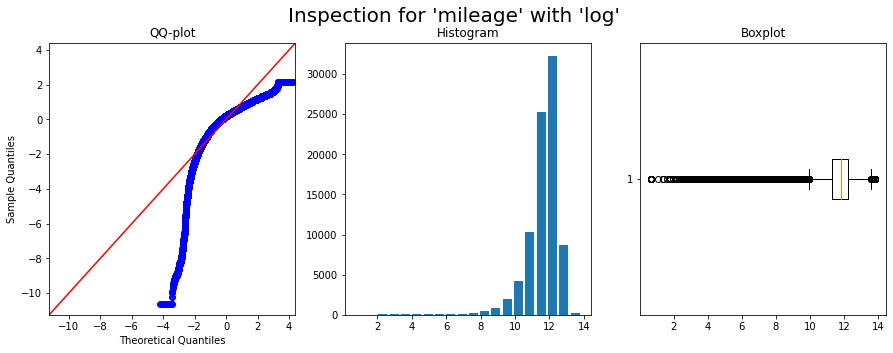

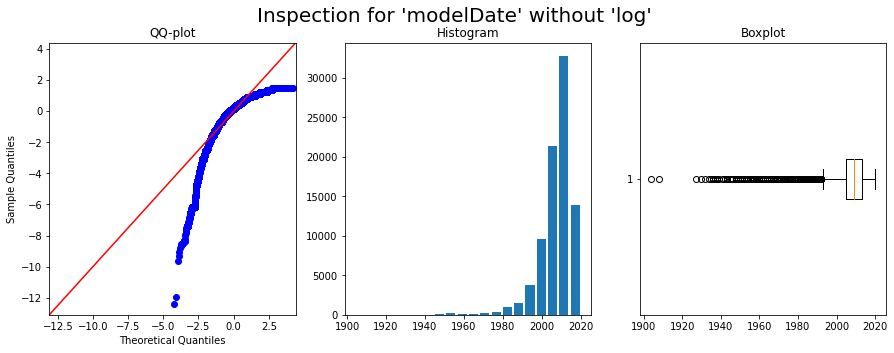

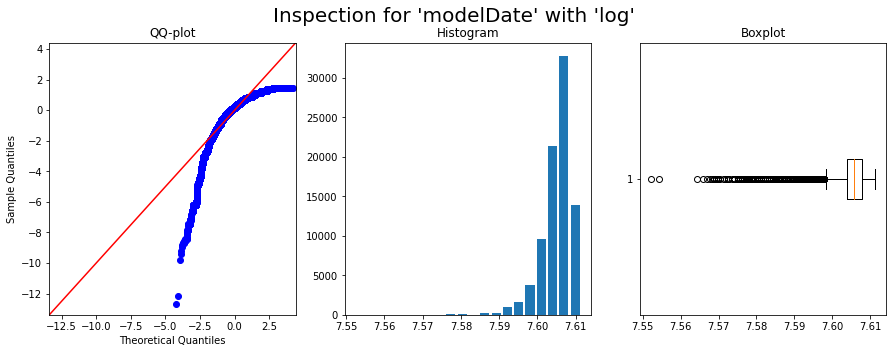

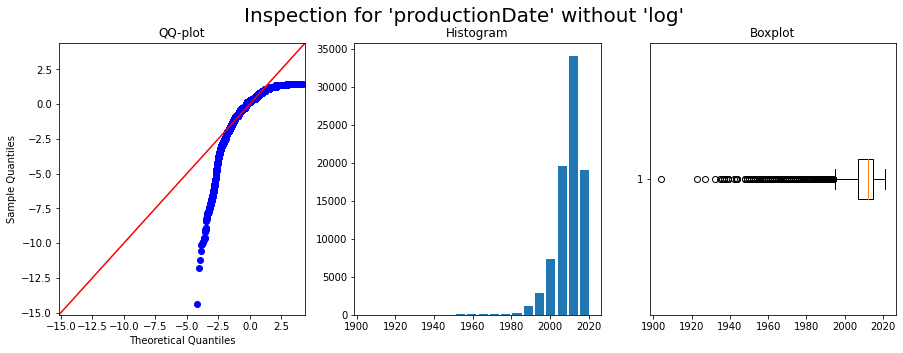

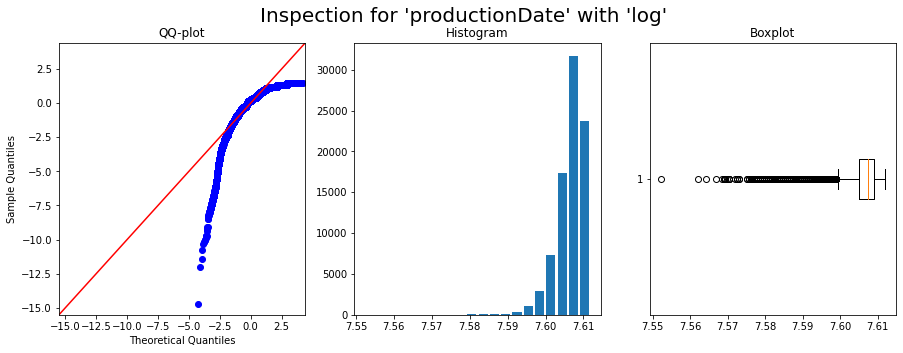

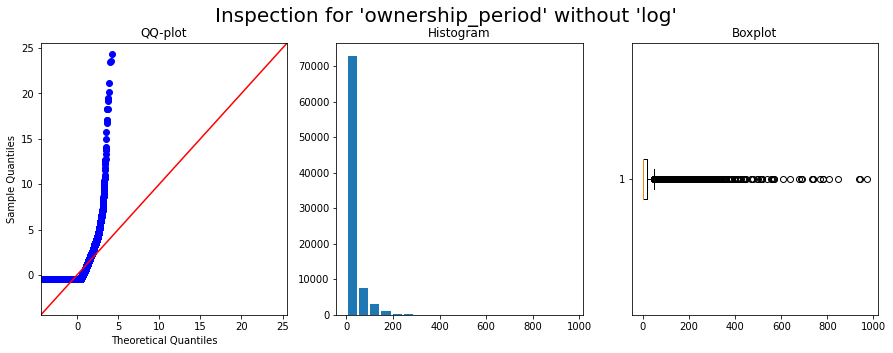

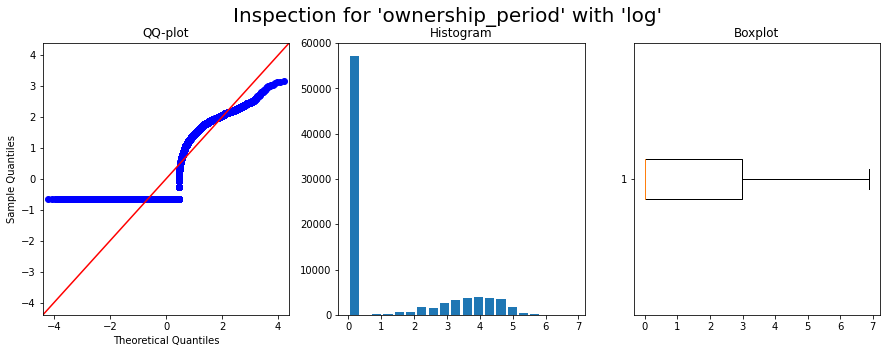

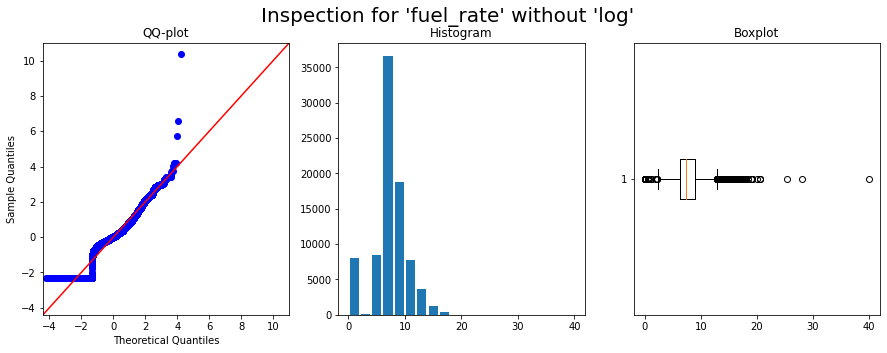

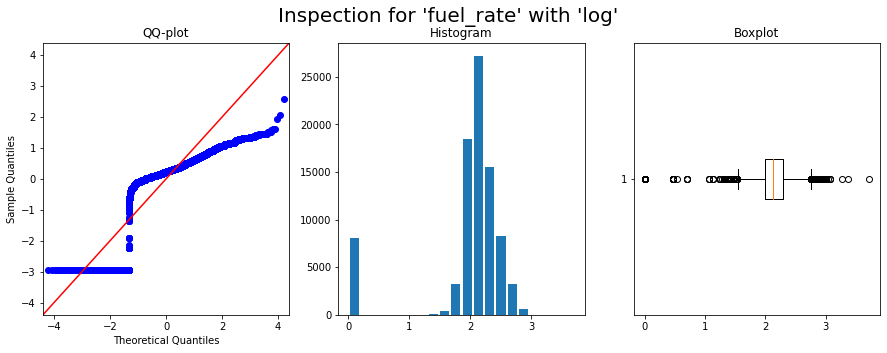

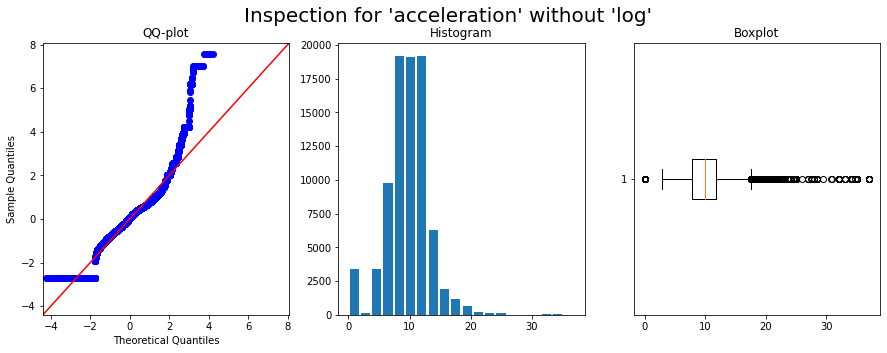

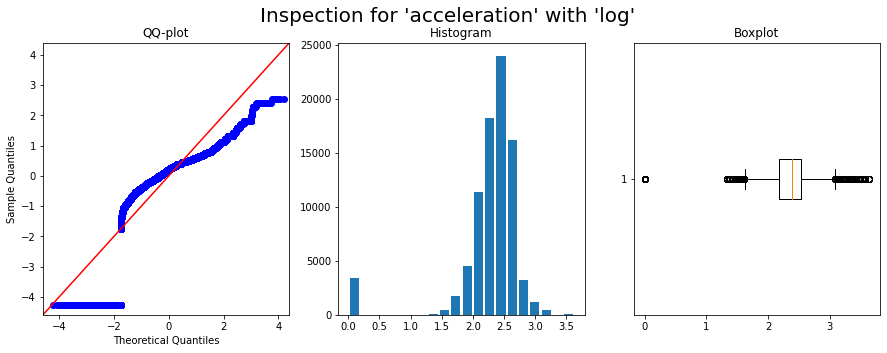

In [43]:
# проанализируем цифровые значения в датасете
num_inspector = NumericInspector(data)
for col in num_cols:
    num_inspector.inspect(col)

In [44]:
# признак engineDisplacement
len(data[data['engineDisplacement'] == 0])

166

In [45]:
data['engineDisplacement'].describe()

count    84969.000000
mean         2.295335
std          0.965285
min          0.000000
25%          1.600000
50%          2.000000
75%          2.700000
max          8.100000
Name: engineDisplacement, dtype: float64

In [46]:
len(data.query('engineDisplacement >= 4.35'))

5195

In [47]:
# создадим признак электрокара, а также избавимся от выбросов
data['is_electro'] = data['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

In [48]:
# cоздаём категориальный признак объема двигателя
data['engineDisplacement_cat'] = data['engineDisplacement'].apply(lambda x: 1 if 0 <= x <=1.1 else 2 if 1.2 <= x <= 1.7
                                                                 else 3 if 1.8 <= x <= 3.5 else 4)

In [49]:
# анализ и устранение выбросов
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 4.35 if x >= 4.35 else x)

In [50]:
# логарифмируем
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)

In [51]:
# аналогичные манипуляции для мощности двигателя
data['enginePower'].describe()

count    84969.000000
mean       177.937471
std         90.382270
min          7.000000
25%        115.000000
50%        150.000000
75%        215.000000
max        963.000000
Name: enginePower, dtype: float64

In [52]:
len(data.query('enginePower >= 365'))

4081

In [53]:
# создаем категориальный признак и избавляемся от выбросов
data['enginePower_cat'] = data['enginePower'].apply(lambda x: 1 if 0 <= x <= 70 else 2 if 71 <= x <= 100 
                                                    else 3 if 101 <= x <= 150 else 4 if 151 <= x <= 200
                                                   else 5)

In [54]:
data['enginePower'] = data['enginePower'].apply(lambda x: 365 if x >= 365 else x)

In [55]:
# логарифмируем

data['enginePower'] = np.log(data['enginePower'] + 1)

In [56]:
# аналогичные действия для пробега
data['mileage'].describe()

count      84969.000000
mean      148414.669338
std        95161.748672
min            1.000000
25%        80000.000000
50%       136000.000000
75%       199388.000000
max      1000000.000000
Name: mileage, dtype: float64

In [57]:
len(data.query('mileage >= 378470'))

1944

In [58]:
data['mileage_cat'] = data['mileage'].apply(lambda x: 1 if 0 <= x <= 100000 else 2 if 100001 <= x <= 300000 else 3)

In [59]:
# modelDate и productionDate
# Эти признаки содержат выбросы, создадим дополнительные признаки старого производства / модели на основании нижней границы выбросов
data['is_old_model'] = data['modelDate'].apply(lambda x: 1 if x <= 1993 else 0)

In [60]:
data['is_old_prod'] = data['productionDate'].apply(lambda x: 1 if x <= 1995 else 0)

In [61]:
# ownership_period
# Признак времени владения. Более 60% имеют нулевые значения, скорее всего это связано с пропусками в данных
# Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные 
len(data.query('ownership_period == 0'))

57190

In [62]:
data['period_unknown'] = data.ownership_period.apply(lambda x: 1 if x == 0 else 0)

In [63]:
data['ownership_period'] = np.log(data['ownership_period'] + 1)

In [64]:
# Рассмотрим признаки fuel_rate и acceleration
data.query('fuel_rate == 0').sample(10)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,ownership_period,pts,gear_type,steering_wheel,sample,price,fuel_rate,acceleration,is_electro,engineDisplacement_cat,enginePower_cat,mileage_cat,is_old_model,is_old_prod,period_unknown
38621,0,11,11,None,Продам хороший брутальный кроссовер немецкого ...,1.677097,5.659482,"{'engine-proof': True, 'cruise-control': True,...",0,220000,1999,1343,5,2003,1103381087,0,2,3,1.098612,1,2,1,1,510000.0,0.0,7.5,0,4,5,2,0,0,0
49013,0,58,11,None,Требуется замена прокладки ГБЦ. .Торг.,1.252763,4.663439,{},3,310000,1997,596,5,1998,1095085442,0,4,3,0.000000,1,2,1,1,190000.0,0.0,0.0,0,3,3,3,0,0,1
79233,0,117,4,None,"Покупал машину для покатушек, перебрал практич...",1.223775,4.343805,{},0,2000,1985,91,5,2002,1101082630,2,5,3,0.000000,1,2,1,1,250000.0,0.0,28.0,0,3,2,1,1,0,1
76352,8,115,1,None,никаких обменов и торговых площадок!!! Эксклюз...,1.504077,5.638355,"{'tinted-glass': True, 'esp': True, 'adaptive-...",0,138000,2008,1281,5,2013,1067922912,0,3,1,0.000000,1,2,0,1,2500000.0,0.0,0.0,0,3,5,2,0,0,1
7040,11,120,4,None,"Продаю очень надёжный автомобиль. Двигатель, к...",1.223775,4.948760,"{'cruise-control': True, 'tinted-glass': True,...",0,303928,2004,1055,4,2007,1100318278,0,2,3,3.951244,0,1,1,0,NaN,0.0,10.6,0,3,3,3,0,0,0
33751,11,11,0,None,"Покупалась машинка под проект, но не сложилось...",1.029619,4.634729,None,0,350000,1982,103,4,1987,1101369192,2,2,3,2.079442,0,0,1,0,NaN,0.0,0.0,0,4,3,3,1,1,0
39299,0,11,15,None,"Автомобиль покупался 2 года назад,по вин можно...",1.677097,5.771441,"{'engine-proof': True, 'cruise-control': True,...",0,380000,2003,1343,5,2005,1103354248,0,2,3,0.000000,0,2,1,1,670000.0,0.0,7.0,0,4,5,3,0,0,1
46981,11,45,15,None,NaN,1.223775,4.615121,"{'passenger-seat-updown': True, 'steel-wheels'...",0,75000,1985,68,4,1988,1091971024,2,5,2,5.981414,1,0,1,1,200000.0,0.0,18.0,0,3,2,1,1,1,0
3849,11,9,11,None,"Являюсь вторым владельцем с 2012 года,состояни...",1.029619,5.099866,"{'ptf': True, 'aux': True, 'usb': True, 'dark-...",0,227000,2004,177,4,2006,1101210314,1,2,2,4.564348,1,1,1,0,NaN,0.0,8.6,0,4,4,2,0,0,0
66487,11,87,4,None,В хорошем состоянии. . На полном ходу. Заданяя...,1.029619,4.744932,"{'alloy-wheel-disks': True, 'tinted-glass': Tr...",0,260000,1999,959,4,2001,1103112175,2,3,3,3.526361,1,1,1,1,153000.0,0.0,11.0,0,4,3,2,0,0,0


In [65]:
# заменяем нулевые значения медианой
data['fuel_rate'].describe()

count    84969.000000
mean         7.326574
std          3.151901
min          0.000000
25%          6.300000
50%          7.400000
75%          8.900000
max         40.000000
Name: fuel_rate, dtype: float64

In [66]:
data['acceleration'].describe()

count    84969.000000
mean         9.762716
std          3.603004
min          0.000000
25%          7.800000
50%          9.900000
75%         11.700000
max         37.000000
Name: acceleration, dtype: float64

In [67]:
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 7.4 if x == 0 else x)

In [68]:
# обработаем выбросы
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 3.4 if x <= 3.4 else x)
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 12.8 if x >= 12.8 else x)

In [69]:
data['fuel_rate'] = np.log(data['fuel_rate'] + 1)

In [70]:
data['acceleration'] = data['acceleration'].apply(lambda x: 9.9 if x == 0 else x)

In [71]:
data['acceleration'] = np.log(data['acceleration'] + 1)

In [72]:
# выделим обучающую часть и отследим корреляцию
train_data = data.query('sample == 1').drop(['sample'], axis=1)

In [73]:
cat_cols.extend(['engineDisplacement_cat', 'enginePower_cat', 'mileage_cat'])
bin_cols.extend(['is_electro', 'period_unknown'])

<AxesSubplot:>

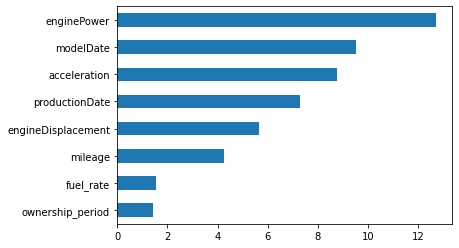

In [74]:
imp_num = Series(f_classif(train_data[num_cols], train_data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

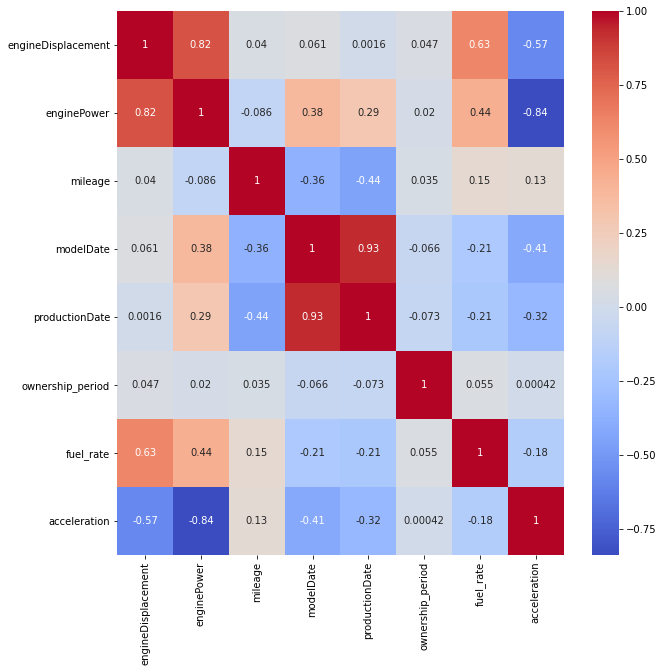

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

<AxesSubplot:>

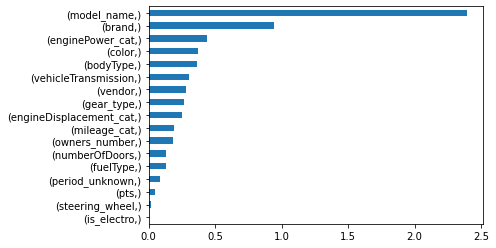

In [76]:
# анализируем значимость признаков с учетом добавленных категориальных признаков

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

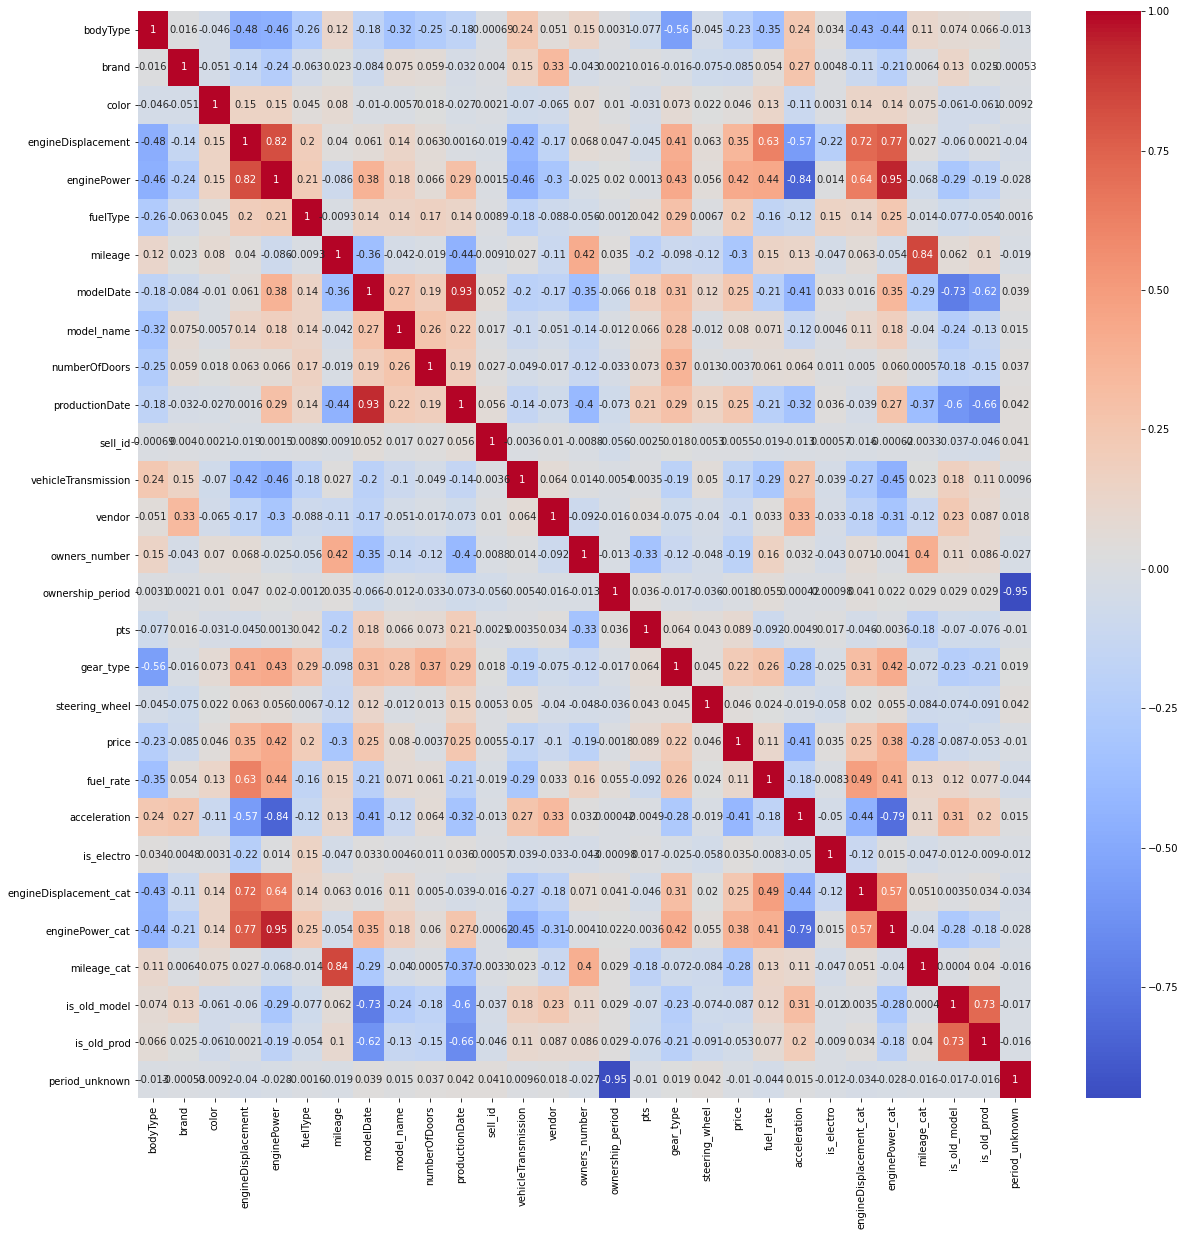

In [77]:
# Посмотрим общую корреляцию
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_data.corr(), 
                 annot=True, cmap='coolwarm')

In [78]:
# создадим новый признак на основе предыдущего анализа
data['body_model_door_gear'] = (data['bodyType'] + data['model_name']) * data['gear_type'] + (2*data['numberOfDoors'])

In [79]:
# признак description
# при обработке данного признака были выделены часто используемые слова и 
# добавлен бинарный признак наличия слова в описании, улучшающий искомую метрику
# преобразуем в нижний регистр, заполним пропуски
data['description'] = data['description'].apply(
    lambda x: x.lower() if type(x) == str else x)
data['description'] = data['description'].fillna('ничего')

# проанализируем, выделив слова
analyzer = CountVectorizer().build_analyzer()
docs = []
for document in data['description']:
    docs.append(analyzer(document))

# соберем слова в единый список, отфильтров короткие (чаще - предлоги, союзы)
all_words = []
for i in docs:
    for x in i:
        if len(x) > 3:
            all_words.append(x)


# Введем переменную для подсчета объектов с помощью модуля collections.
c = collections.Counter()

# Пройдемся циклом и подсчитаем количество значений для каждого слова. Посмотрим самые часто встречающиеся
for i in all_words:
    c[i] += 1

print(c.most_common(50))

[('автомобиль', 69550), ('автомобиля', 60009), ('пробегом', 49389), ('система', 44050), ('автомобилей', 32965), ('автомобили', 30555), ('состоянии', 29779), ('более', 27857), ('кредит', 27649), ('авто', 26428), ('есть', 23865), ('салон', 23838), ('машина', 23584), ('вашего', 21034), ('безопасности', 20364), ('сидений', 19361), ('комплектация', 18904), ('руля', 18583), ('торг', 17458), ('обогрев', 17259), ('зеркал', 17218), ('водителя', 17137), ('года', 17113), ('день', 16824), ('комплект', 16798), ('покупке', 16707), ('салона', 16693), ('контроль', 16657), ('передние', 16533), ('пробег', 16211), ('только', 16024), ('диски', 16005), ('подушки', 15845), ('рольф', 15567), ('дилера', 15291), ('юридической', 15270), ('фары', 15109), ('обслуживание', 14956), ('чистоты', 14122), ('датчик', 14003), ('официального', 13943), ('оригинал', 13822), ('подогрев', 13684), ('обмен', 13350), ('каско', 13304), ('пассажира', 13297), ('гарантия', 12911), ('кредита', 12584), ('рублей', 12459), ('отличном', 

In [80]:
# добавим новый признак
data['word_каско'] = data['description'].apply(
    lambda x: 1 if 'каско' in x else 0)

## Выводы

Как видно, на цену автомобиля больше всего влияют следующие признаки: объем двигателя, мощность, пробег, разгон, год производства. Модель и тип топлива также имеют большое значение. Model_date и production_date сильно кореллируют, один из признаков будет удален.
Далее поэкспериментируем, сначала построим наивную модель и посмотрим метрику mape.

## Naive model

In [81]:
train_data = data.query('sample == 1').drop([
    'sample',
    'complectation_dict',
    'description',
    'equipment_dict'
], axis=1)

X = train_data.drop(['price'], axis=1)
y = train_data['price']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [83]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [84]:
# Находим медианное значение по engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(
    tmp_train.groupby('engineDisplacement')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 98.27%


## Стекинг

In [85]:
# очищаем сет от невостребованных данных
train_data = data.query('sample == 1').drop([
    'sample',
    'complectation_dict',
    'description',
    'equipment_dict',
    'productionDate',
    'is_old_model',
    'engineDisplacement_cat',
    'vehicleTransmission'
], axis=1)

X = train_data.drop(['price'], axis=1)
y = train_data['price']

# разделяем сет на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# стандартизируем
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [86]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

## Подбор параметров для модели

In [87]:
# # Поиск лучших параметров для CatBoostRegressor 

# model = CatBoostRegressor(
#     random_seed=RANDOM_SEED,
#     eval_metric='MAPE',
#     custom_metric=['MAE'],
#     silent=True,
#     task_type='GPU'
# )

# grid = {
#     'learning_rate': [0.03, 0.05, 0.1],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'iterations': [int(x) for x in np.linspace(start=1000, stop=5000, num=20)]
# } 

# grid_search_result = model.grid_search(
#     grid,
#     X=X_train_st,
#     y=np.log(y_train),
#     plot=True
# )

In [88]:
# # Поиск лучших параметров для XGBRegressor (поиск занимает очень большой промежуток времени)

# find_best_params(
#     estimator=xgb.XGBRegressor(colsample_bytree=0.5, alpha=1),
#     parameters={
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [1, 3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'objective': ['reg:squarederror'],
#         'n_estimators': [int(x) for x in np.linspace(start=1000, stop=2000, num=5)]
#     },
#     x_train=X_train_st,
#     y_train=np.log(y_train)
# )

## Финальное обучение

In [89]:
estimators = [
    ('cat_boost', CatBoostRegressor(
        random_seed=RANDOM_SEED,
        eval_metric='MAPE',
        iterations=4200,
        l2_leaf_reg=4,
        depth=7,
        custom_metric=['MAE'],
        loss_function='RMSE',
        learning_rate=0.08,
        verbose=1
    ))
]

reg = StackingRegressor(
    estimators=estimators,
    cv=cv,
    verbose=10,
    passthrough=True,
    n_jobs=-1,
    final_estimator=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.5,
        learning_rate=0.03,
        max_depth=11,
        alpha=1,
        n_jobs=-1,
        n_estimators=1200,
        seed=RANDOM_SEED
    )
)

reg.fit(X_train_st, np.log(y_train))
y_pred = np.exp(reg.predict(X_test_st))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 15.78%


## Submission

In [90]:
X_sub = data.query('sample == 0').drop([
    'sample',
    'complectation_dict',
    'description',
    'equipment_dict',
    'productionDate',
    'is_old_model',
    'engineDisplacement_cat',
    'vehicleTransmission',
    'price'
], axis=1)

In [91]:
X_sub = scaler.transform(X_sub)

In [92]:
predict_submission = np.exp(reg.predict(X_sub))*0.87

In [93]:
sample_submission = pd.read_csv('../input/sf-dst-car-price-prediction/sample_submission.csv')

In [94]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('./submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.807285e+05
1,1100549428,8.841466e+05
2,1100658222,8.443210e+05
3,1100937408,8.336372e+05
4,1101037972,6.742044e+05
5,1100912634,6.166813e+05
6,1101228730,6.342655e+05
7,1100165896,4.201721e+05
8,1100768262,1.865039e+06
9,1101218501,7.802477e+05
